In [17]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime

# Create synthetic time-series data
from statsmodels.tsa.arima_process import ArmaProcess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

# Set up a seed for reproducibility
np.random.seed(42)

# Autoregressive coefficients
arparams = np.array([.95, .05])

# Moving average coefficients
maparams = np.array([.6, .3])

# Create a ARMA process
arma_process = ArmaProcess.from_coeffs(arparams, maparams)

# Create the control time-series
X = 10 + arma_process.generate_sample(nsample=500)

# Create the response time-series
y = 2 * X + np.random.normal(size=500)

# Add the true causal impact
y[300:] += 10

In [18]:
# Create dates
dates = pd.date_range('2021-01-01', freq='D', periods=500)

# Create dataframe
df = pd.DataFrame({'dates': dates, 'y': y, 'X': X}, columns=['dates', 'y', 'X'])

# Set dates as index
df.set_index('dates', inplace=True)

# Take a look at the data
df.head()

df.to_csv("medium_blod_dataset.csv")

In [19]:
# Print out the time series start date
print(f'The time-series start date is :{df.index.min()}')

# Print out the time series end date
print(f'The time-series end date is :{df.index.max()}')

# Print out the intervention start date
print(f'The treatment start date is :{df.index[300]}')

The time-series start date is :2021-01-01 00:00:00
The time-series end date is :2022-05-15 00:00:00
The treatment start date is :2021-10-28 00:00:00


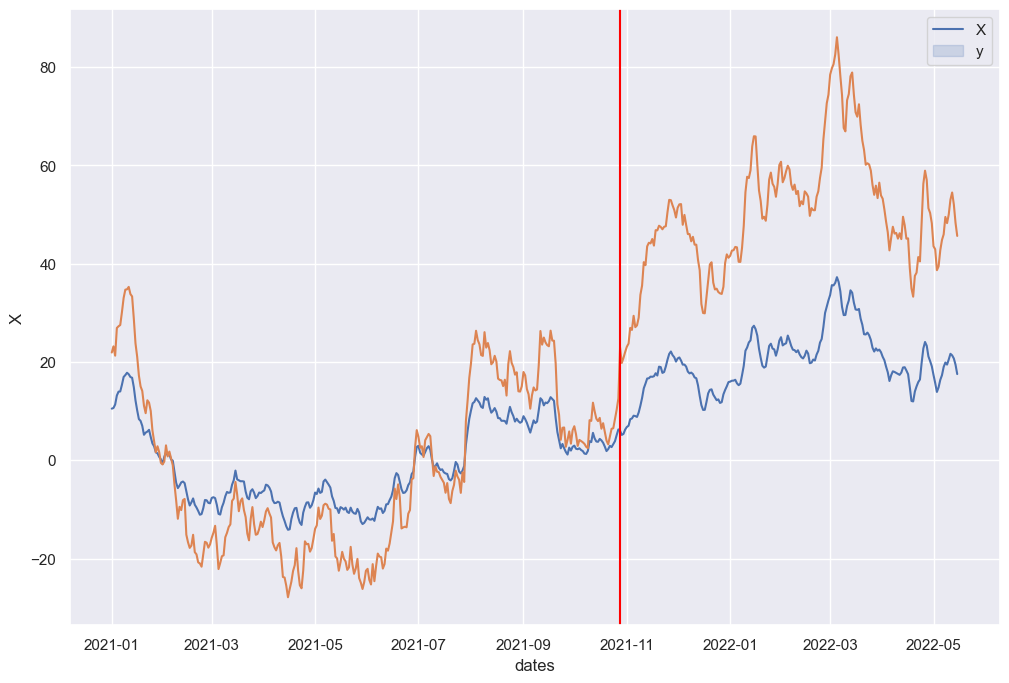

In [20]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=df.index, y=df['X'])
sns.lineplot(x=df.index, y=df['y'])
plt.axvline(x= df.index[300], color='red')
plt.legend(labels = ['X', 'y'])

In [21]:
# Set pre-period
pre_period = [str(df.index.min())[:10], str(df.index[299])[:10]]

# Set post-period
post_period = [str(df.index[300])[:10], str(df.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2021-01-01', '2021-10-27']
The post-period is ['2021-10-28', '2022-05-15']


In [22]:
# Calculate the pre-daily average
pre_daily_avg = df['y'][:300].mean()

# Calculate the post-daily average
post_daily_avg = df['y'][300:].mean()

# Print out the results
print(f'The pre-treatment daily average is {pre_daily_avg}.')
print(f'The post-treatment daily average is {post_daily_avg}.')
print(f'The raw difference between the pre and the post treatment is {post_daily_avg - pre_daily_avg}.')

The pre-treatment daily average is -1.6403416947312546.
The post-treatment daily average is 50.08461262581729.
The raw difference between the pre and the post treatment is 51.72495432054855.


In [23]:
# Causal impact model
impact = CausalImpact(data=df, pre_period=pre_period, post_period=post_period)
impact.run()
# Visualization
impact.plot()

AttributeError: 'NoneType' object has no attribute 'iloc'

<Figure size 1500x1200 with 0 Axes>

In [ ]:
# Causal impact summary
print(impact.summary())

AttributeError: 'NoneType' object has no attribute 'loc'

In [ ]:
# Causal impact report
print(impact.summary(output='report'))

AttributeError: 'NoneType' object has no attribute 'loc'